In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import optuna

import warnings
warnings.filterwarnings('ignore')

EDA = False
SINGLE_PARAM_OPT = False
OPTUNA = False

In [2]:
# Import data
train = pd.read_csv('/kaggle/input/playground-series-s3e23/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e23/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67842 entries, 0 to 67841
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 67842 non-null  int64  
 1   loc                67842 non-null  float64
 2   v(g)               67842 non-null  float64
 3   ev(g)              67842 non-null  float64
 4   iv(g)              67842 non-null  float64
 5   n                  67842 non-null  float64
 6   v                  67842 non-null  float64
 7   l                  67842 non-null  float64
 8   d                  67842 non-null  float64
 9   i                  67842 non-null  float64
 10  e                  67842 non-null  float64
 11  b                  67842 non-null  float64
 12  t                  67842 non-null  float64
 13  lOCode             67842 non-null  int64  
 14  lOComment          67842 non-null  int64  
 15  lOBlank            67842 non-null  int64  
 16  locCodeAndComment  678

In [6]:
train.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [7]:
test.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,101763,33.0,5.0,1.0,4.0,144.0,824.82,0.04,26.96,30.05,...,1257.60,30,0,3,0,21.0,23.0,87.0,57.0,9.0
1,101764,27.0,8.0,8.0,2.0,125.0,646.24,0.04,22.82,27.22,...,804.58,23,0,2,0,18.0,19.0,70.0,49.0,15.0
2,101765,130.0,11.0,7.0,10.0,545.0,3831.40,0.02,48.15,66.17,...,6453.34,99,9,17,1,26.0,53.0,333.0,244.0,21.0
3,101766,65.0,7.0,1.0,7.0,156.0,855.71,0.06,17.23,49.89,...,896.42,45,8,10,0,15.0,26.0,88.0,60.0,13.0
4,101767,22.0,3.0,1.0,3.0,52.0,238.42,0.10,9.60,26.70,...,145.80,16,0,4,0,12.0,15.0,30.0,24.0,5.0


In [14]:
# Check data dimension
print(f"Train set dimensional : {train.shape}")
print(f"Test set dimensional : {test.shape}")

Train set dimensional : (101763, 23)
Test set dimensional : (67842, 22)


In [15]:
# Check data duplication
print('Duplication in train set: ', train.duplicated().sum())
print('Duplication in test set: ', test.duplicated().sum())

Duplication in train set:  0
Duplication in test set:  0


In [9]:
train.eq(0).sum()

id                       1
loc                      0
v(g)                     0
ev(g)                    0
iv(g)                    0
n                     7835
v                     7864
l                     7899
d                     7871
i                     7870
e                     7900
b                     8097
t                     7901
lOCode                7818
lOComment            72851
lOBlank              19324
locCodeAndComment    93550
uniq_Op               7795
uniq_Opnd             7866
total_Op              7834
total_Opnd            7899
branchCount              0
defects              78699
dtype: int64

In [10]:
test.eq(0).sum()

id                       0
loc                      0
v(g)                     0
ev(g)                    0
iv(g)                    0
n                     5314
v                     5341
l                     5359
d                     5355
i                     5347
e                     5367
b                     5505
t                     5368
lOCode                5307
lOComment            48449
lOBlank              12994
locCodeAndComment    62302
uniq_Op               5281
uniq_Opnd             5348
total_Op              5312
total_Opnd            5362
branchCount              0
dtype: int64

In [11]:
train['defects'].value_counts()

defects
False    78699
True     23064
Name: count, dtype: int64

In [12]:
train.describe()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,50881.000000,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,29376.592059,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25440.500000,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,50881.000000,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,76321.500000,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,101762.000000,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


In [24]:
zero = ["n","v","l","d","i","e","b","t","lOCode","lOComment","lOBlank","locCodeAndComment","uniq_Op","uniq_Opnd","total_Op","total_Opnd","branchCount", "defects"]
for i in zero:
    print(train[i].value_counts())


n
0.0       7835
15.0      1430
22.0      1390
27.0      1383
29.0      1311
          ... 
1019.0       1
966.0        1
1257.0       1
923.0        1
733.0        1
Name: count, Length: 836, dtype: int64
v
0.00        7864
60.94        494
66.61        477
51.89        446
48.43        440
            ... 
665.29         1
496.17         1
1846.54        1
2660.79        1
12955.16       1
Name: count, Length: 4515, dtype: int64
l
0.00    7899
0.05    7861
0.04    7076
0.06    6863
0.03    6209
0.07    5335
0.08    5276
0.11    5195
0.09    4747
0.10    4584
0.13    4310
0.12    3830
0.02    3369
0.14    2922
0.15    2529
0.17    2365
0.16    2235
0.29    1886
0.19    1874
0.18    1556
0.33    1429
0.25    1408
0.20    1383
0.40    1264
0.22    1121
0.21    1052
0.50    1036
0.24     841
0.01     714
0.23     552
0.28     471
0.27     468
0.30     394
0.67     330
0.34     290
0.26     246
0.36     140
0.32     138
0.42     129
0.44     125
0.38      94
0.35      55
0.31      39
0.41

# **Data Preprocessing**

In [26]:
# Calculate the correlation matrix
correlation_matrix = train.corr()



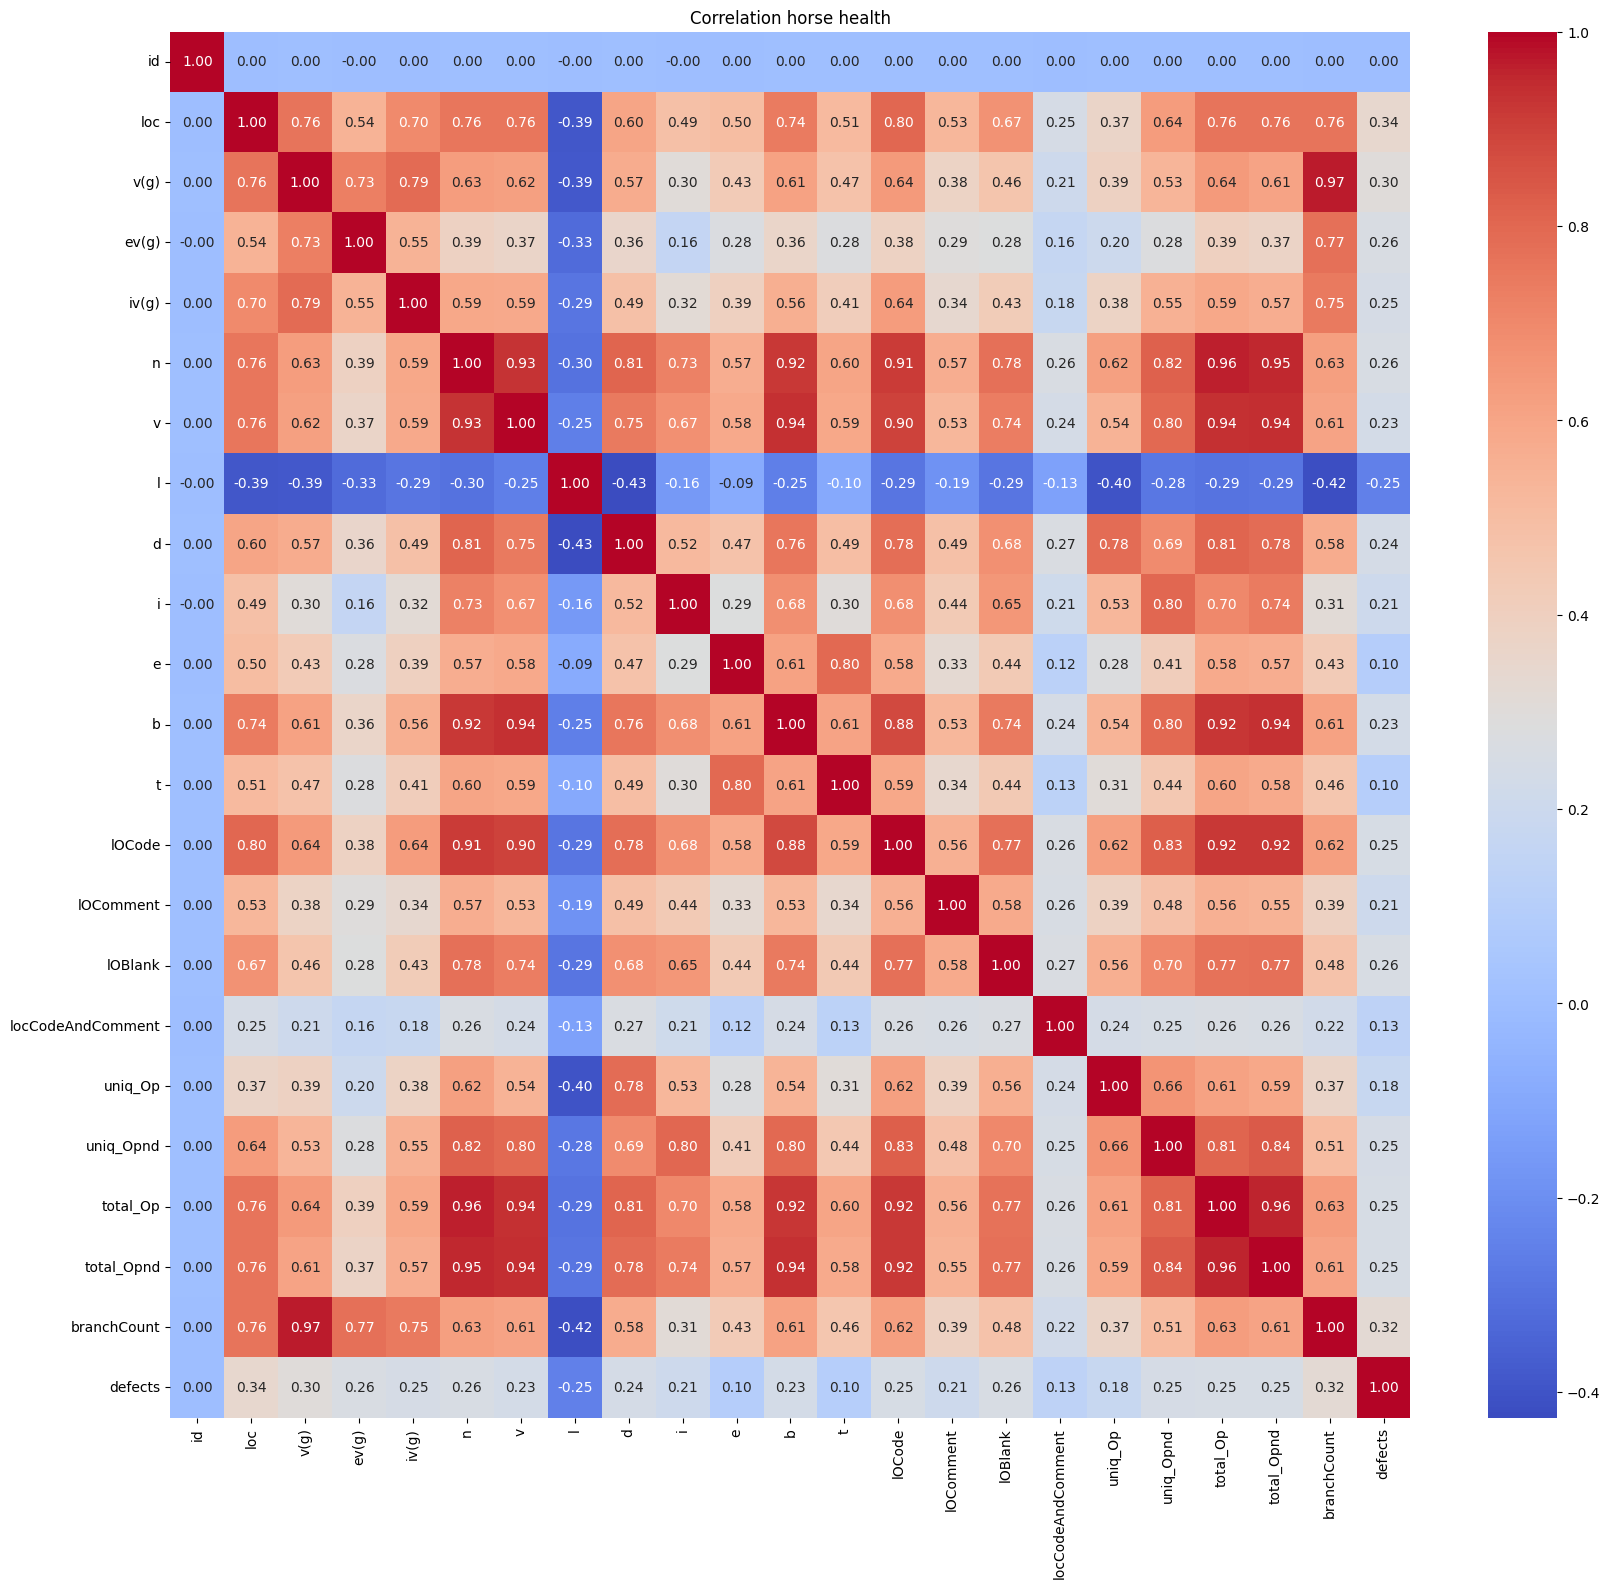

In [27]:
# Create a heatmap using Seaborn
plt.figure(figsize=(20,18)) # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation horse health")
plt.show()

In [28]:
train.skew().to_frame()

,0
id,0.000000
loc,11.818912
v(g),14.258631
ev(g),6.513498
iv(g),28.209964
n,9.908514
v,15.959869
l,1.903337
d,5.618081
i,4.859743


In [30]:
# Calculate the correlation matrix
correlation_matrix = test.corr()

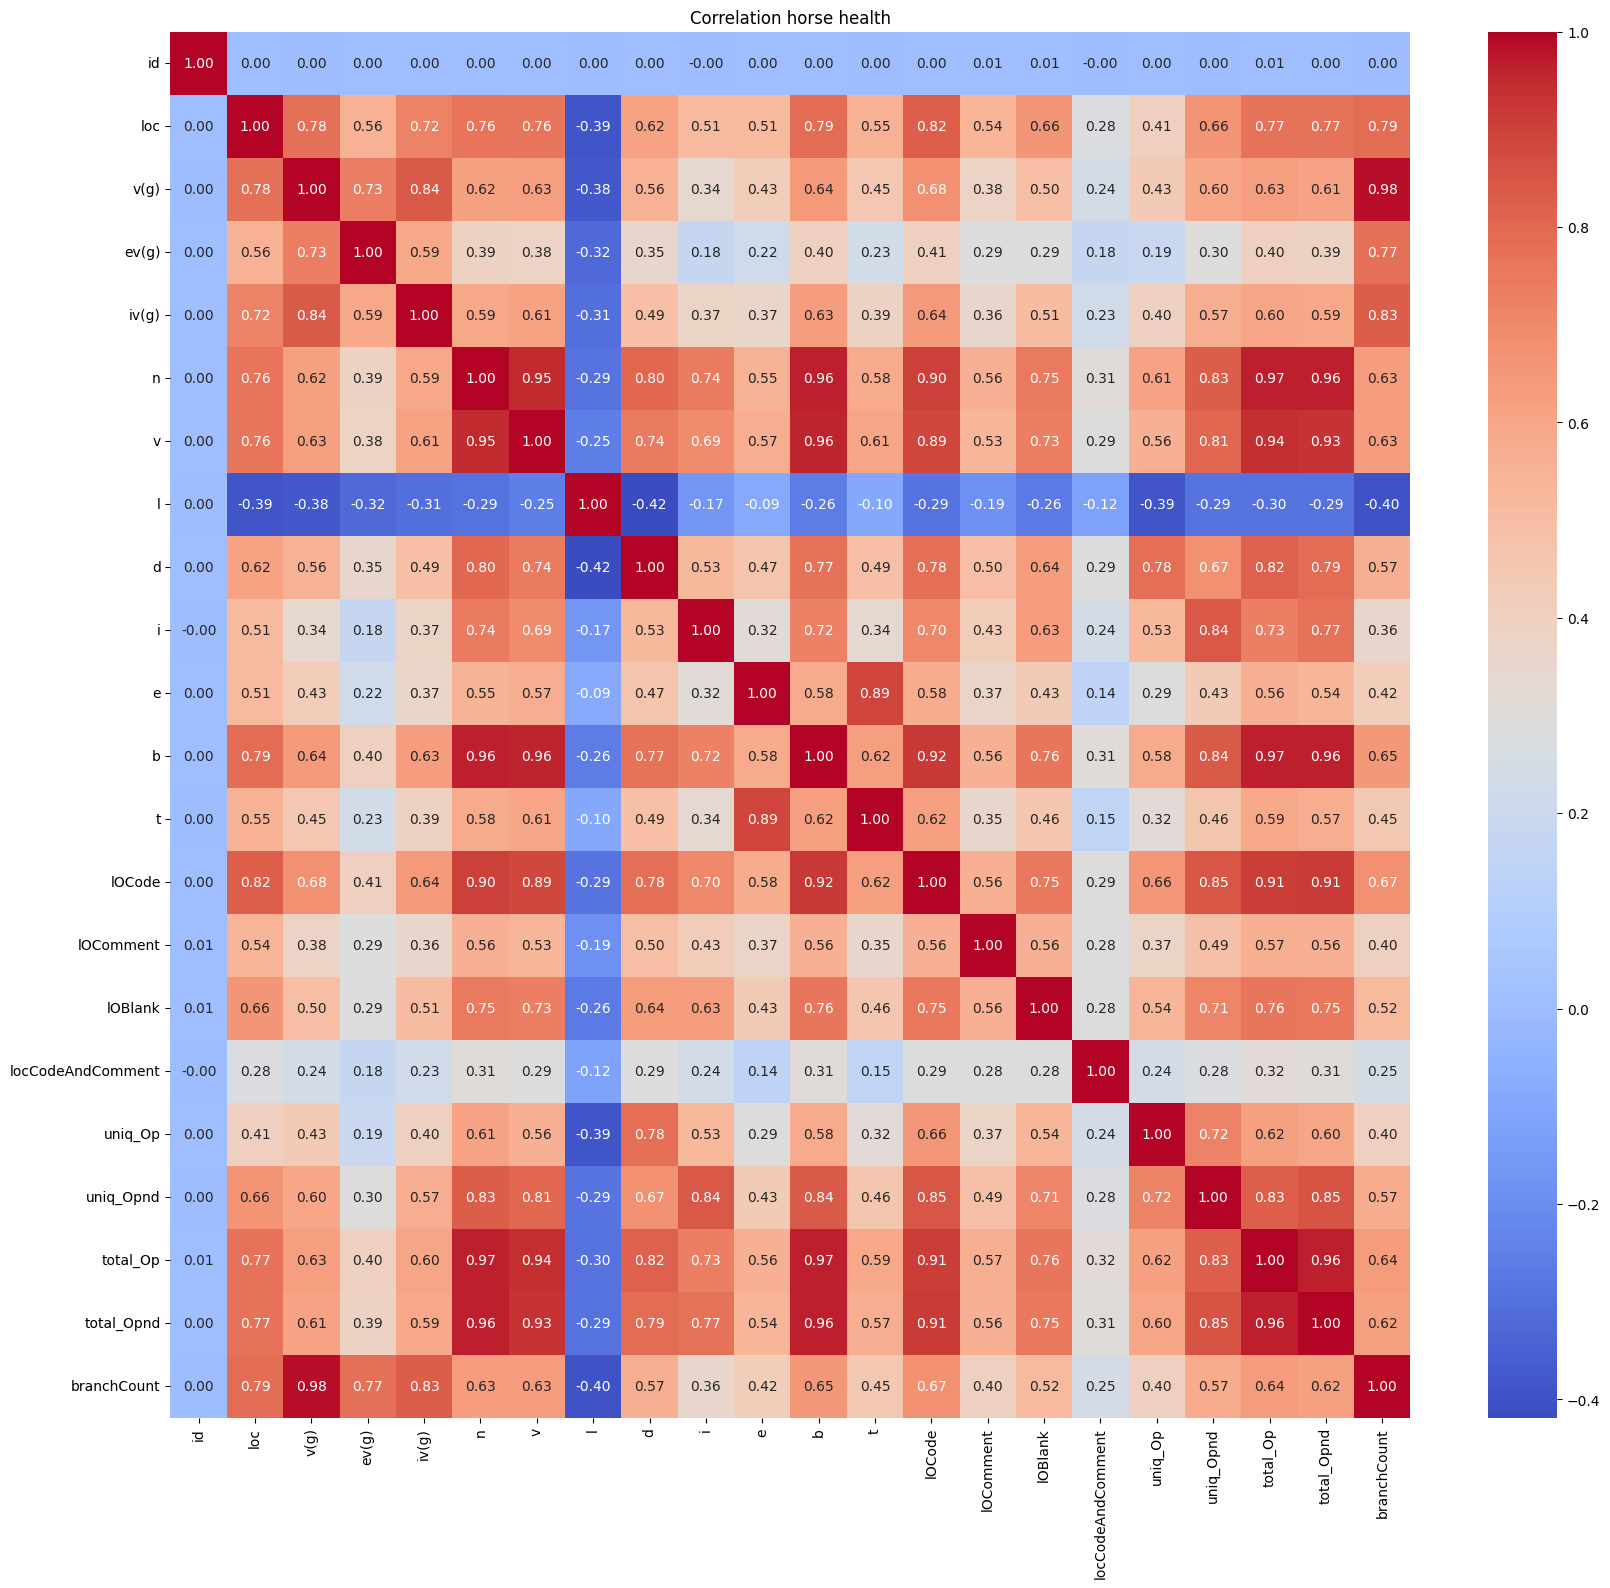

In [31]:
# Create a heatmap using Seaborn
plt.figure(figsize=(20,18)) # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation horse health")
plt.show()

In [29]:
test.skew().to_frame()

,0
id,0.000000
loc,9.543532
v(g),14.514528
ev(g),6.516306
iv(g),23.026535
n,9.999277
v,15.745668
l,1.943179
d,5.542591
i,5.200868


In [32]:
train_data = train.copy()
test_data = test.copy()

In [36]:
train_data.columns
test_data.columns

Index(['id', 'loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e',
       'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment',
       'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount'],
      dtype='object')

In [38]:
 lOCode_mean = train_data["lOCode"].median()
 train_data["lOCode"] = train_data["lOCode"].replace(0, lOCode_mean)

In [39]:
X = train_data.drop(columns = ["defects","id","b",'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment'])


In [40]:
X = train_data.drop(columns = ["defects"])

y = train_data["defects"]

In [41]:
X1 = test_data.drop(columns = ["id","b",'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment'])
X1 = test_data

In [42]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

# **Logistic Regression**

In [43]:
# Create a pipeline with preprocessing and logistic regression

lg_model = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('logistic_regression', LogisticRegression(max_iter=6000))  # Logistic Regression
])

# Fit the pipeline on the training data
lg_model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_pred_proba = lg_model.predict_proba(X_test)[:, 1]

# Calculate the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {roc_auc}")

AUC-ROC Score: 0.7765898687611297


In [44]:
lg_model.score(X_test, y_test)

0.8092664472068

In [45]:
y_pred = lg_model.predict_proba(X1)[:, 1]
y_pred

array([0.23581516, 0.21909783, 0.5504763 , ..., 0.17300526, 0.13958581,
       0.63830152])

# **Random Forest Regression**

In [46]:
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline with StandardScaler and Random Forest Classifier
pipeline = Pipeline([
    
    ('scaler', StandardScaler()),          # Standardize features
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42))  # Random Forest Classifier
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred1 = pipeline.predict_proba(X_test)

# Calculate the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred1[:, 1])
print(f"AUC-ROC Score: {roc_auc:.2f}")

AUC-ROC Score: 0.77


In [47]:
from sklearn.ensemble import RandomForestRegressor
# Create a pipeline with Random Forest Regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest Regression
])

# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

# Predict on the test data
y_pred2 = pipe.predict(X_test)

In [48]:
# # Calculate the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred2)
print(f"AUC-ROC Score: {roc_auc}")
# from sklearn.metrics import mean_squared_error
# # Calculate Mean Squared Error (MSE) as an example metric
# mse = mean_squared_error(y_test, y_pred2)
# print(f"Mean Squared Error: {mse:.2f}")

AUC-ROC Score: 0.7665276824142148


In [84]:
y_test_pred = pipe.predict(X1)

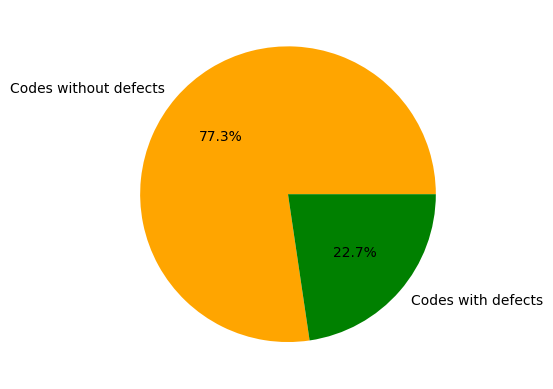

In [89]:
# The two classes are imbalanced
class_counts = np.bincount(train.defects.astype(int))
plt.pie(class_counts,labels=['Codes without defects', 'Codes with defects'], colors=['orange','green'], autopct='%1.1f%%');



In [91]:
train.describe()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,50881.000000,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,29376.592059,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25440.500000,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,50881.000000,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,76321.500000,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,101762.000000,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


In [92]:
if EDA:
    # Float features' histograms
    plt.figure(figsize=(15,15))

    # Figure index
    idx = 0

    for col in train.columns:
        if train[col].dtype == 'float64':
            # Histogram of a feature for code with, without defects in the train dataset, and features in the test set
            for df in [train[train.defects], train[~train.defects], test]:
                idx +=1
                plt.subplot(20,3,idx)
                df[col].hist(color='gray')
                plt.xticks([])
                plt.yticks([])
                plt.yscale('log')

            # Add the title to highlight the feature name
            plt.title(col)

    # Tight layout for figures' organization
    plt.tight_layout()

In [93]:
# Extract features
X = train.copy().drop(['id','defects'],axis=1)

In [94]:
if EDA:
    # Feature correlations
    sns.heatmap(X.corr());

In [95]:
# Extract target
y = train.copy().defects.astype(int)

In [96]:
# Train_val data split for model evaluation
train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.1,random_state=0)

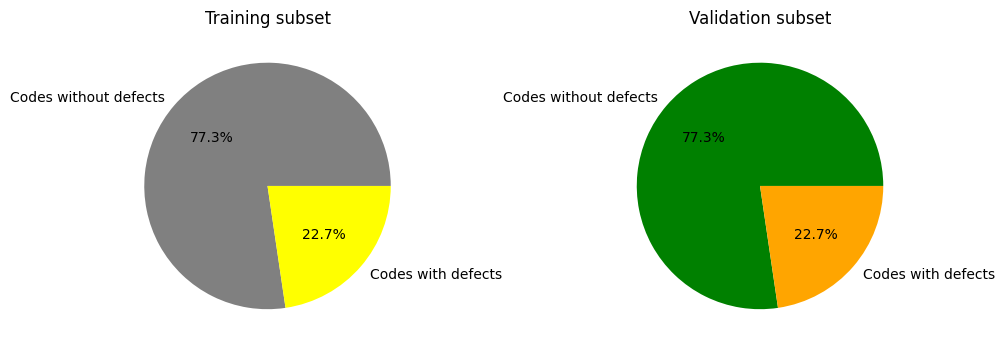

In [99]:
plt.figure(figsize=(10,5))
# The sub_train dataset
plt.subplot(1,2,1)
class_counts = np.bincount(train_y.astype(int))
plt.pie(class_counts,labels=['Codes without defects', 'Codes with defects'], colors=['grey','yellow'], autopct='%1.1f%%');
plt.title('Training subset')

# The validation dataset
plt.subplot(1,2,2)
class_counts = np.bincount(val_y.astype(int))
plt.pie(class_counts,labels=['Codes without defects', 'Codes with defects'], colors=['green','orange'], autopct='%1.1f%%');
plt.title('Validation subset')

plt.tight_layout();

In [124]:
if EDA:
    # Float features' histograms in train and val subsets
    plt.figure(figsize=(15,15))

    # Figure index
    idx = 0

    for col in train.columns:
        if train[col].dtype == 'float64':
            # Histogram of a feature for code with, without defects in the train dataset, and features in the test set
            for name, df in zip(['train','val'],[train_X, val_X]):
                idx +=1
                plt.subplot(20,2,idx)
                df[col].hist(color='gray')
                plt.xticks([])
                plt.yticks([])
                plt.yscale('log')
                plt.title(col + '_' + name)
        # Tight layout for figures' organization
                plt.tight_layout()# XGBoost is an excellent model for tabular datasets

 

**XGBOOST**

In [125]:
xgb_params = {'objective':'binary:logistic', 
              'n_estimators':100,
              'learning_rate':0.03858856691681774,
              'max_depth':None,
              'gamma':5,
              'scale_pos_weight':77.3/22.7,
              'random_state':0}

xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(train_X,train_y, 
          eval_set=[(train_X,train_y),(val_X,val_y)], 
          early_stopping_rounds=5, 
          verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03858856691681774,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

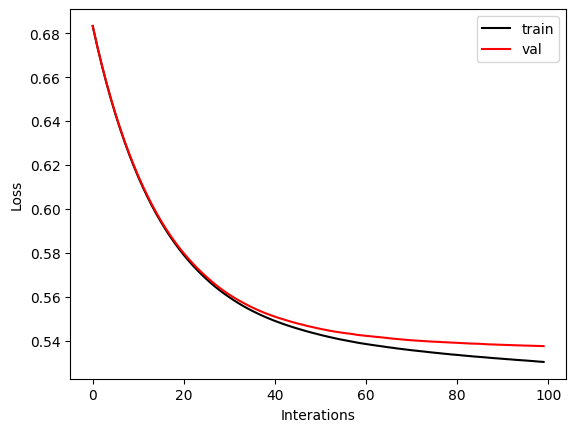

In [103]:
# Training history
plt.plot(xgb_model.evals_result()['validation_0']['logloss'], 'k', label='train')
plt.plot(xgb_model.evals_result()['validation_1']['logloss'], 'r', label='val')
plt.ylabel('Loss')
plt.xlabel('Interations')
plt.legend();



In [104]:
# Prediction
xgb_prediction = xgb_model.predict_proba(val_X)[:,1]
xgb_prediction[xgb_prediction>1]=1
xgb_prediction[xgb_prediction<0]=0

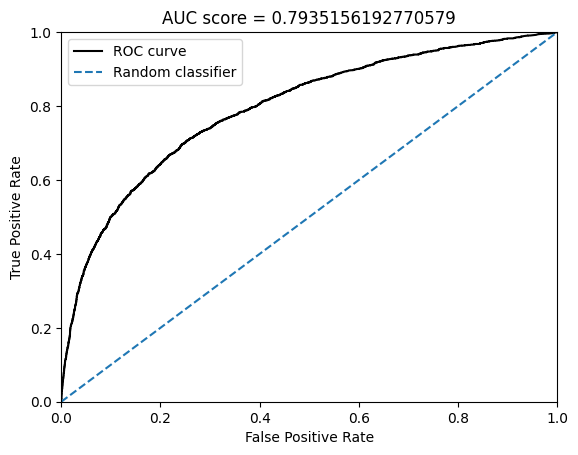

In [105]:
def plot_roc(val_y,pred_y):
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(val_y,pred_y, pos_label=1)

    plt.plot(fpr, tpr, 'k', label='ROC curve')

    # Plot the baseline
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

    # Set the axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Set axis limits
    plt.xlim(0,1)
    plt.ylim(0,1)

    # Set the title
    plt.title('AUC score = ' + str(roc_auc_score(val_y,pred_y)))

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()
    
plot_roc(val_y,xgb_prediction)

In [106]:
# Evaluation of the AUC score on the validation subset
xgb_auc_score = roc_auc_score(val_y,xgb_prediction)
print('The AUC score evaluated on the validation subset using XGBoost model: ', xgb_auc_score)

The AUC score evaluated on the validation subset using XGBoost model:  0.7935156192770579


In [107]:
if SINGLE_PARAM_OPT:
    
    params = {'objective':'binary:logistic', 
          'n_estimators':100,
          'learning_rate':0.1,
          'max_depth':None,
          'gamma':5,
          'scale_pos_weight':77.3/22.7,
          'random_state':0
         }
        
    def get_auc_score(model, X,y,n_estimators):
        train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.1,random_state=0)
        
        model = XGBClassifier(**params)

        model.fit(train_X,train_y, 
              eval_set=[(train_X,train_y),(val_X,val_y)], 
              early_stopping_rounds=5, 
              verbose=0)

        prediction = model.predict_proba(val_X)[:,1]

        auc_score = roc_auc_score(val_y,prediction)

        return auc_score


    
    # Single hyper parameter optimization
    for n_estimators in [100,150,200]:
        auc_score = get_auc_score(xgb_model,X,y,n_estimators)
        print(f'Number of estimators: {n_estimators}, auc score: {auc_score}.')

In [109]:
kfold = KFold(n_splits=5,shuffle=True,random_state=0)
skfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

In [110]:
if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def xgb_objective(trial):

        # Set the hyperparameters of the XGBoost classifier.
        params = {'objective':'binary:logistic', 
                  'n_estimators':100,
                  'learning_rate':trial.suggest_float('learning_rate',0.03,0.3),
                  'max_depth':None,
                  'gamma':5,
                  'scale_pos_weight':77.3/22.7,
                  'random_state':0
                 }

        xgb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):
            train_X = X.iloc[train_idx]
            val_X = X.iloc[val_idx]
            train_y = y[train_idx]
            val_y = y[val_idx]

            xgb_model = XGBClassifier(**params)

            xgb_model.fit(train_X,train_y)

            xgb_prediction = xgb_model.predict_proba(val_X)[:,1]
            xgb_prediction[xgb_prediction>1]=1
            xgb_prediction[xgb_prediction<0]=0
            xgb_auc_score = roc_auc_score(val_y, xgb_prediction)
            print(f'The AUC score evaluated on the validation subset using XGB model for fold {idx}: ', xgb_auc_score)

            xgb_auc_score_avg += xgb_auc_score
            
        xgb_auc_score_avg /=5
        print(f'The averaged AUC score evaluated on the validation subset using XGB model:', xgb_auc_score_avg)
        return -xgb_auc_score_avg

    xgb_study = optuna.create_study()
    xgb_study.optimize(xgb_objective, n_trials=100)
    best_xgb_params = xgb_study.best_trial.params

    print('Best XGB hyper parameters:', best_xgb_params)


In [111]:
def get_auc_score(model, X,y,n_estimators):
        train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.1,random_state=0)
        
        model = XGBClassifier(**params)

        model.fit(train_X,train_y, 
              eval_set=[(train_X,train_y),(val_X,val_y)], 
              early_stopping_rounds=5, 
              verbose=0)

        prediction = model.predict_proba(val_X)[:,1]

        auc_score = roc_auc_score(val_y,prediction)

        return auc_score


**Light GBM**

In [112]:
if True:
    def lgb_objective(trial):
        params = {'boosting_type': 'gbdt', 
                  'colsample_bytree': 1.0, 
                  'learning_rate': 0.09273502446736404, 
                  'max_depth': -1, 
                  'min_child_samples': 20, 
                  'min_child_weight': 0.001, 
                  'min_split_gain': 0.0, 
                  'n_jobs': -1, 
                  'num_leaves': 10, 
                  'random_state': None, 
                  'reg_alpha': 0.8978200441138784,
                  'reg_lambda': 0.0020343781703193705, 
                  'subsample': 1.0, 
                  'subsample_for_bin': 200000, 
                  'subsample_freq': 0, 
                  'verbose': -1, 
                  'objective': 'binary', 
                  'metric': ['auc'], 
                  'num_iterations': 100, 
                  'early_stopping_round': None}

        lgb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):
            train_X = X.iloc[train_idx]
            val_X = X.iloc[val_idx]
            train_y = y[train_idx]
            val_y = y[val_idx]

            lgb_model = LGBMClassifier(**params)

            lgb_model.fit(train_X,train_y)

            # Select the best model
            bst = lgb_model.booster_

            lgb_prediction = lgb_model.predict_proba(val_X, num_iteration=bst.best_iteration)[:,1]
            lgb_prediction[lgb_prediction>1]=1
            lgb_auc_score = roc_auc_score(val_y, lgb_prediction)
            print(f'The AUC score evaluated on the validation subset using LGB model for fold {idx}: ', lgb_auc_score)

            lgb_auc_score_avg += lgb_auc_score
            
        lgb_auc_score_avg /=5
        print(f'The averaged AUC score evaluated on the validation subset using LGB model:', lgb_auc_score_avg)
        return -lgb_auc_score_avg

    lgb_study = optuna.create_study()
    lgb_study.optimize(lgb_objective, n_trials=100)
    best_lgb_params = lgb_study.best_trial.params

    print('Best LGBM parameters:', best_lgb_params)



[I 2023-10-06 10:01:01,775] A new study created in memory with name: no-name-5ce4dc94-5110-4a62-ac9d-e1648ad09bd0


The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:06,272] Trial 0 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:10,615] Trial 1 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:14,873] Trial 2 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:19,204] Trial 3 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:23,351] Trial 4 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:27,556] Trial 5 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:32,792] Trial 6 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:37,067] Trial 7 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:41,133] Trial 8 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:45,213] Trial 9 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:49,460] Trial 10 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:53,542] Trial 11 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:01:57,680] Trial 12 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:02,728] Trial 13 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:06,885] Trial 14 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:10,967] Trial 15 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:15,048] Trial 16 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:19,206] Trial 17 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:23,437] Trial 18 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:27,692] Trial 19 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:32,930] Trial 20 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:37,250] Trial 21 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:41,486] Trial 22 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:45,813] Trial 23 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:50,054] Trial 24 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:54,560] Trial 25 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:02:58,782] Trial 26 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:03,536] Trial 27 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:08,098] Trial 28 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:12,266] Trial 29 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:16,535] Trial 30 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:20,633] Trial 31 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:24,768] Trial 32 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:28,894] Trial 33 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:33,005] Trial 34 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:38,052] Trial 35 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:42,074] Trial 36 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:46,169] Trial 37 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:50,190] Trial 38 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:54,209] Trial 39 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:03:58,376] Trial 40 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:02,429] Trial 41 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:07,550] Trial 42 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:11,559] Trial 43 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:15,740] Trial 44 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:19,944] Trial 45 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:23,977] Trial 46 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:28,071] Trial 47 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:32,337] Trial 48 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:36,513] Trial 49 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:41,525] Trial 50 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:45,852] Trial 51 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:49,971] Trial 52 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:54,050] Trial 53 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:04:58,178] Trial 54 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:02,199] Trial 55 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:06,470] Trial 56 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:11,516] Trial 57 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:15,651] Trial 58 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:19,934] Trial 59 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:24,071] Trial 60 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:28,354] Trial 61 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:32,551] Trial 62 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:37,026] Trial 63 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:42,218] Trial 64 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:46,492] Trial 65 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:50,563] Trial 66 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:54,650] Trial 67 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:05:58,924] Trial 68 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:03,277] Trial 69 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:07,658] Trial 70 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:12,945] Trial 71 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:17,227] Trial 72 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:21,462] Trial 73 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:25,846] Trial 74 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:30,106] Trial 75 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:34,384] Trial 76 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:38,574] Trial 77 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:42,748] Trial 78 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:48,094] Trial 79 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:52,482] Trial 80 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:06:56,940] Trial 81 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:01,430] Trial 82 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:05,723] Trial 83 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:09,809] Trial 84 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:13,891] Trial 85 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:18,984] Trial 86 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:23,146] Trial 87 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:27,350] Trial 88 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:31,699] Trial 89 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:35,827] Trial 90 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:39,968] Trial 91 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:44,053] Trial 92 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:49,206] Trial 93 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:53,244] Trial 94 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:07:57,415] Trial 95 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:08:01,613] Trial 96 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:08:05,800] Trial 97 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:08:09,922] Trial 98 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
The AUC score evaluated on the validation subset using LGB model for fold 0:  0.7903312926206282
The AUC score evaluated on the validation subset using LGB model for fold 1:  0.7893281954677007
The AUC score evaluated on the validation subset using LGB model for fold 2:  0.795452282387408
The AUC score evaluated on the validation subset using LGB model for fold 3:  0.7880340881915693


[I 2023-10-06 10:08:14,103] Trial 99 finished with value: -0.7920409559893908 and parameters: {}. Best is trial 0 with value: -0.7920409559893908.


The AUC score evaluated on the validation subset using LGB model for fold 4:  0.7970589212796477
The averaged AUC score evaluated on the validation subset using LGB model: 0.7920409559893908
Best LGBM parameters: {}


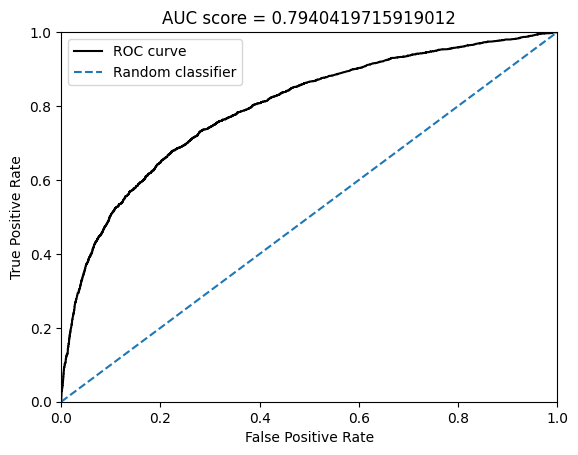

In [114]:
train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.1,random_state=0)

lgb_params = {'boosting_type': 'gbdt', 
              'colsample_bytree': 1.0, 
              'learning_rate': 0.09273502446736404, 
              'max_depth': -1, 
              'min_child_samples': 20, 
              'min_child_weight': 0.001, 
              'min_split_gain': 0.0, 
              'n_jobs': -1, 
              'num_leaves': 10, 
              'random_state': None, 
              'reg_alpha': 0.8978200441138784,
              'reg_lambda': 0.0020343781703193705, 
              'subsample': 1.0, 
              'subsample_for_bin': 200000, 
              'subsample_freq': 0, 
              'verbose': -1, 
              'objective': 'binary', 
              'metric': ['auc'], 
              'num_iterations': 100, 
              'early_stopping_round': None}

lgb_model = LGBMClassifier(**lgb_params)

lgb_model.fit(train_X,train_y)
lgb_prediction = lgb_model.predict_proba(val_X)[:,1]

plot_roc(val_y,lgb_prediction)

**CatBoost**

In [115]:
if OPTUNA:
    def cb_objective(trial):
        params = {'iterations':100, #The number of trees to grow.
          'learning_rate':trial.suggest_float('learning_rate',0.01,0.3), #The learning rate controls how quickly the model learns from the data.
          'depth':trial.suggest_int('depth',5,10), #The maximum depth of the trees.
          'subsample':trial.suggest_float('subsample',0.7,0.9), #The proportion of the training data to use for each iteration.
          'colsample_bylevel':0.8, #The proportion of features to use at each level of the tree.
          'min_data_in_leaf':20, #The minimum number of data points in a leaf node.
          'loss_function':'Logloss', #The loss function to optimize.
          }

        cb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):
            train_X = X.iloc[train_idx]
            val_X = X.iloc[val_idx]
            train_y = y[train_idx]
            val_y = y[val_idx]

            cb_model = CatBoostClassifier(**params)

            cb_model.fit(train_X,train_y,verbose=0)

            cb_prediction = cb_model.predict_proba(val_X)[:,1]
            cb_prediction[cb_prediction>1]=1
            cb_auc_score = roc_auc_score(val_y, cb_prediction)
            print(f'The AUC score evaluated on the validation subset using Catboost model for fold {idx}: ', cb_auc_score)

            cb_auc_score_avg += cb_auc_score
            
        cb_auc_score_avg /=5
        print(f'The averaged AUC score evaluated on the validation subset using Catboost model:', cb_auc_score_avg)
        return -cb_auc_score_avg

    cb_study = optuna.create_study()
    cb_study.optimize(cb_objective, n_trials=100)
    best_cb_params = cb_study.best_trial.params

    print('Best Catboost parameters:', best_cb_params)

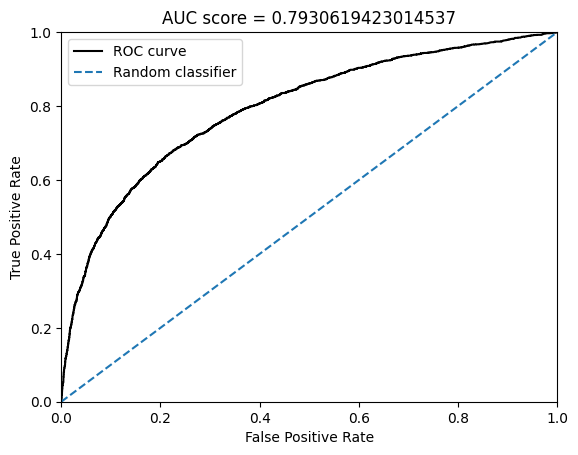

In [116]:
train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.1,random_state=0)

cb_params = {'iterations':100, #The number of trees to grow.
          'learning_rate': 0.14809770038609973, #The learning rate controls how quickly the model learns from the data.
          'depth': 5, #The maximum depth of the trees.
          'subsample': 0.8041397165621115, #The proportion of the training data to use for each iteration.
          'colsample_bylevel':0.8, #The proportion of features to use at each level of the tree.
          'min_data_in_leaf':20, #The minimum number of data points in a leaf node.
          'loss_function':'Logloss', #The loss function to optimize.
          }

cb_model = CatBoostClassifier(**cb_params)

cb_model.fit(train_X,train_y,verbose=0)
cb_prediction = cb_model.predict_proba(val_X)[:,1]

plot_roc(val_y,cb_prediction)

**Prediction for the test set**

In [117]:
X_test = test.copy().drop('id',axis=1)

In [118]:
lgb_params = {'boosting_type': 'gbdt', 
              'colsample_bytree': 1.0, 
              'learning_rate': 0.09273502446736404, 
              'max_depth': -1, 
              'min_child_samples': 20, 
              'min_child_weight': 0.001, 
              'min_split_gain': 0.0, 
              'n_jobs': -1, 
              'num_leaves': 10, 
              'random_state': None, 
              'reg_alpha': 0.8978200441138784,
              'reg_lambda': 0.0020343781703193705, 
              'subsample': 1.0, 
              'subsample_for_bin': 200000, 
              'subsample_freq': 0, 
              'verbose': -1, 
              'objective': 'binary', 
              'metric': ['auc'], 
              'num_iterations': 100, 
              'early_stopping_round': None}

xgb_params = {'objective':'binary:logistic', 
              'n_estimators':100,
              'learning_rate':0.03858856691681774,
              'max_depth':None,
              'gamma':5,
              'scale_pos_weight':77.3/22.7,
              'random_state':0}

cb_params = {'iterations':100, #The number of trees to grow.
          'learning_rate': 0.14809770038609973, #The learning rate controls how quickly the model learns from the data.
          'depth': 5, #The maximum depth of the trees.
          'subsample': 0.8041397165621115, #The proportion of the training data to use for each iteration.
          'colsample_bylevel':0.8, #The proportion of features to use at each level of the tree.
          'min_data_in_leaf':20, #The minimum number of data points in a leaf node.
          'loss_function':'Logloss', #The loss function to optimize.
          }

xgb_prediction = np.zeros(len(X_test))
lgb_prediction = np.zeros(len(X_test))
cb_prediction = np.zeros(len(X_test))
for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):
    train_X = X.iloc[train_idx]
    val_X = X.iloc[val_idx]
    train_y = y[train_idx]
    val_y = y[val_idx]

    # LGBMClassifier
    lgb_model = LGBMClassifier(**lgb_params)

    lgb_model.fit(train_X,train_y)

    lgb_prediction += lgb_model.predict_proba(X_test)[:,1]
    
    # XGBClassifier
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(train_X,train_y)
    
    xgb_prediction += xgb_model.predict_proba(X_test)[:,1]
    
    # CatBoostClassifier
    cb_model = CatBoostClassifier(**cb_params)
    cb_model.fit(train_X,train_y)
    
    cb_prediction += cb_model.predict_proba(X_test)[:,1]
    
xgb_prediction /=5
lgb_prediction /=5
cb_prediction /=5

0:	learn: 0.6149678	total: 13.9ms	remaining: 1.37s
1:	learn: 0.5608202	total: 27.3ms	remaining: 1.34s
2:	learn: 0.5227020	total: 40.3ms	remaining: 1.3s
3:	learn: 0.4963537	total: 55.1ms	remaining: 1.32s
4:	learn: 0.4797868	total: 69ms	remaining: 1.31s
5:	learn: 0.4659552	total: 84.1ms	remaining: 1.32s
6:	learn: 0.4562506	total: 98.2ms	remaining: 1.3s
7:	learn: 0.4497569	total: 111ms	remaining: 1.27s
8:	learn: 0.4452702	total: 124ms	remaining: 1.25s
9:	learn: 0.4419495	total: 137ms	remaining: 1.23s
10:	learn: 0.4387935	total: 151ms	remaining: 1.22s
11:	learn: 0.4364901	total: 164ms	remaining: 1.2s
12:	learn: 0.4350566	total: 177ms	remaining: 1.19s
13:	learn: 0.4339330	total: 191ms	remaining: 1.17s
14:	learn: 0.4331522	total: 204ms	remaining: 1.15s
15:	learn: 0.4324440	total: 218ms	remaining: 1.15s
16:	learn: 0.4317669	total: 232ms	remaining: 1.13s
17:	learn: 0.4314082	total: 246ms	remaining: 1.12s
18:	learn: 0.4310324	total: 260ms	remaining: 1.11s
19:	learn: 0.4306643	total: 272ms	remai

In [119]:
# Ensemble
prediction = 0.1*xgb_prediction+0.8*lgb_prediction+0.1*cb_prediction
prediction[prediction>1]=1
prediction[prediction<0]=0

In [120]:
# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test.id, 'defects':prediction})
submission.head(3)

,id,defects
0,101763,0.272713
1,101764,0.220931
2,101765,0.686130


In [121]:
submission.defects[submission.defects>1]=1
submission.head(3)

,id,defects
0,101763,0.272713
1,101764,0.220931
2,101765,0.686130


In [122]:
submission.to_csv('submission.csv',index=False)

In [123]:
output = pd.DataFrame({'id': test_data["id"], 'outcome': y_pred})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
